In [1]:
import pickle as pkl
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import torch
import seaborn as sns

In [2]:
with open("data/target_ts.pkl", 'rb') as f:
    data = pkl.load(f)
with open("data/mask_target.pkl", 'rb') as f:
    mask = pkl.load(f)


In [3]:
data.shape

(200086, 200, 11)

In [4]:
table = pq.read_table('data/info_ts.parquet')

In [5]:
info = table.to_pandas()

In [6]:
info.reset_index(inplace=True)

In [7]:
info = info.loc[~(info["id"]=="76adbf4f-ceb6-4649-9776-d4a8b1241a1d"), :]

In [8]:
info

id       date           
                                                    min        max
0       0000272c-937b-4443-b03a-5ced9097d25f 2020-01-01 2023-06-06
1       00005f52-b45c-4e3f-9c9c-b7c896cb38c1 2018-01-01 2021-06-06
2       00006e3a-e587-4d7f-8884-3ab37cbce21e 2019-01-01 2022-06-06
3       0000af21-ce67-4f73-846c-9b4ba100ff19 2021-01-01 2024-06-06
4       0000ea6a-b8dd-4e3d-9a68-2f03e3e3351a 2019-01-01 2022-06-06
...                                      ...        ...        ...
200082  ffff455e-b577-4d30-8f6a-0f0660cab160 2019-01-01 2022-06-06
200083  ffff6484-aebc-440c-8558-1c86677dc1a8 2022-01-01 2025-06-06
200084  ffff948e-d741-4710-b9a9-25fc5ae7c216 2019-01-01 2022-06-06
200085  ffffaa94-7502-431e-8e05-e89fff45b9e8 2022-01-01 2025-06-06
200086  ffffb66c-177f-4d0a-bc68-58b6842e7239 2019-01-01 2022-06-06

[200086 rows x 3 columns]

In [9]:
def monotone_penalty(y_hat,
                     index_list,
                     mask):
    # Differences between consecutive steps
    diff = y_hat[:, :-1, index_list] - y_hat[:, 1:, index_list]  # [B, T-1]
    diff = torch.relu(diff)
    diff_masked = diff * mask[:,1:]
    penalty = diff_masked.sum() / (mask.sum() + 1e-8)
    return penalty

In [10]:
data_tensor = torch.tensor(data, dtype=torch.float32)
mask_tensor = torch.tensor(mask, dtype=torch.float32)

In [11]:
display(data_tensor.size())
display(mask_tensor.size())

torch.Size([200086, 200, 11])

torch.Size([200086, 200, 1])

In [12]:
test_tensor = torch.tensor([0,1,2,3,4,5,6,10,20,21]).unsqueeze(0).unsqueeze(-1).repeat(1,1,5)

In [13]:
test_tensor.shape

torch.Size([1, 10, 5])

In [14]:
test_tensor[:, :-1, 0].shape

torch.Size([1, 9])

In [15]:
data_tensor[:10, :-1, 1].shape

torch.Size([10, 199])

In [16]:
tensor = (test_tensor[:10, :-1, [0,1]] - test_tensor[:10, 1:, [0,1]])

In [17]:
tensor = (data_tensor[0, :-1, 1] - data_tensor[0, 1:, 1])

In [18]:
tensor.max()

tensor(0.1631)

<Axes: >

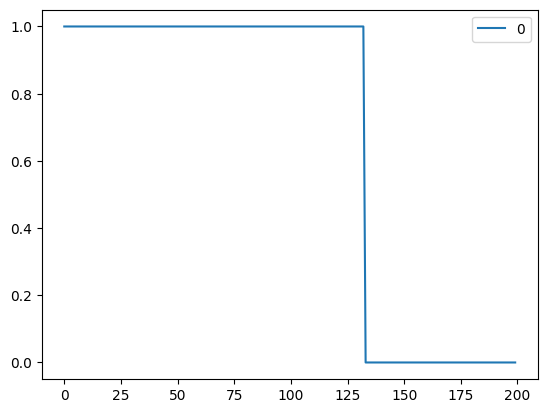

In [19]:
sns.lineplot(mask[100,:])

In [20]:
data_tensor[100,:-1,0] - data_tensor[100,1:,0]

tensor([-0.0102, -0.0082, -0.0087, -0.0084, -0.0089, -0.0074, -0.0067, -0.0068,
        -0.0071, -0.0093, -0.0086, -0.0095, -0.0160, -0.0208, -0.0172, -0.0212,
        -0.0199, -0.0175, -0.0176, -0.0224, -0.0261, -0.0282, -0.0205, -0.0164,
        -0.0147, -0.0171, -0.0147, -0.0158, -0.0144, -0.0165, -0.0192, -0.0154,
        -0.0145, -0.0174, -0.0206, -0.0209, -0.0187, -0.0155, -0.0175, -0.0180,
        -0.0195, -0.0197, -0.0193, -0.0260, -0.0276, -0.0223, -0.0188, -0.0198,
        -0.0175, -0.0178, -0.0209, -0.0213, -0.0177, -0.0217, -0.0306, -0.0306,
        -0.0326, -0.0269, -0.0218, -0.0208, -0.0213, -0.0109, -0.0114, -0.0090,
        -0.0106, -0.0116, -0.0118, -0.0156, -0.0135, -0.0124, -0.0099, -0.0092,
        -0.0116, -0.0086, -0.0078, -0.0089, -0.0084, -0.0080, -0.0085, -0.0117,
        -0.0090, -0.0075, -0.0087, -0.0108, -0.0129, -0.0102, -0.0091, -0.0119,
        -0.0117, -0.0095, -0.0092, -0.0075, -0.0087, -0.0085, -0.0092, -0.0082,
        -0.0068, -0.0060, -0.0055, -0.00

In [21]:
mask.shape

(200086, 200, 1)

/tmp/ipykernel_170452/2413019580.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sns.lineplot((data_tensor[i,:-1,0] - data_tensor[i,1:,0])*mask[i,1:,0])


<Axes: >

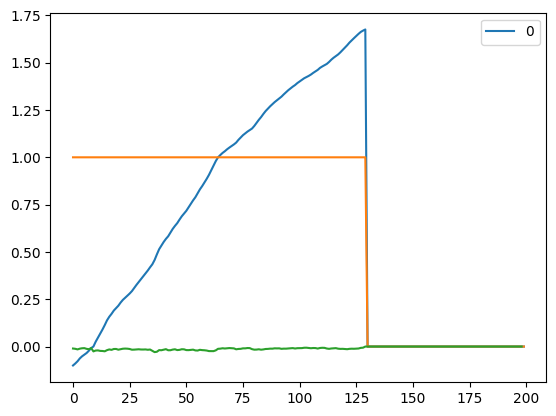

In [22]:
# sns.lineplot(data_tensor[i,:, [0, 2, 3, 4, 5, 6]])
i = 190
sns.lineplot(data_tensor[i,:, [0]])
sns.lineplot(mask[i,:,0])
sns.lineplot((data_tensor[i,:-1,0] - data_tensor[i,1:,0])*mask[i,1:,0])

In [23]:
mono_loss = monotone_penalty(data_tensor[:2,:,:],
                             [0, 2, 3, 4, 5, 6],
                             mask[:2,:,:])

/tmp/ipykernel_170452/3607844035.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff_masked = diff * mask[:,1:]


In [24]:
mono_loss

tensor(0.)

In [29]:
def biomass_penalty(y_hat,
                    index_list,
                    mask):
    '''
    Expected index order in the index_list is: [TAGP, TWSO, TMLV, TWST]

    This function calculates a penalty on the deviations from the equality : TAGP = TWSO + TMLV + TWST
    '''
    mask = mask.squeeze(2)
    y_hat = y_hat[:, :, index_list]

    total_biomass = y_hat[:, :, 0]
    partial_biomass = y_hat[:, :, 1:]
    # Compute the biomass penalty
    inconsistence = (total_biomass - partial_biomass.sum(dim=-1)).abs()
    penalty = (inconsistence * mask).sum() / (mask.sum() + 1e-8)
    return penalty

In [30]:
biomass_penalty_loss = biomass_penalty(data_tensor,
                                       [2, 3, 4, 5],
                                       mask)

/tmp/ipykernel_170452/1599119565.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  penalty = (inconsistence * mask).sum() / (mask.sum() + 1e-8)


In [31]:
biomass_penalty_loss

tensor(0.0001)

In [25]:
def assimilation_penalty(y_hat,
                         index_list,
                         mask):
    '''
    Expected index order in the index_list is: [ASRC, GASS, MRES]

    This function calculates a penalty on the deviations from the equality : ASRC = GASS - MRES
    '''
    mask = mask.squeeze(2)
    y_hat = y_hat[:, :, index_list]

    asrc = y_hat[:, :, 0]
    gass = y_hat[:, :, 1]
    mres = y_hat[:, :, 2]
    # Compute the biomass penalty
    inconsistence = (asrc - (gass - mres)).abs()
    penalty = (inconsistence * mask).sum() / (mask.sum() + 1e-8)
    return penalty

In [26]:
assimialtion_penalty_loss = assimilation_penalty(data_tensor,
                                                 [8, 9, 10],
                                                 mask)

/tmp/ipykernel_152195/2364423266.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  penalty = (inconsistence * mask).sum() / (mask.sum() + 1e-8)


In [27]:
assimialtion_penalty_loss

tensor(3.9265e-06)

In [ ]:
def dry_matter_increase_penalty(y_hat,
                                index_list,
                                mask):
    """
    Expected index order in the index_list is: [TAGP, TWRT, DMI]

    This function calculates a penalty on the deviations from the equality : DMI_{t-1} = (TAGP_{t}-TAGP_{t-1})+(TWRT{t}-TWRT{t-1})
    """
    mask = mask.squeeze(2)
    y_hat = y_hat[:, :, index_list]

    prev_y_hat = y_hat[:, :-1, :]  # Get the previous time step
    curr_y_hat = y_hat[:, 1:, :]  # Get the current time step

    # Compute the dry matter increase penalty
    tagp_diff = curr_y_hat[:, :, 0] - prev_y_hat[:, :, 0]
    twrt_diff = curr_y_hat[:, :, 1] - prev_y_hat[:, :, 1]
    inconsistence = (prev_y_hat[:, :, 2] - (tagp_diff + twrt_diff)).abs()
    #TODO: Nickel le con, j'avais mis mask [:,:-1], une connerie de pas possible, putain de merde j'ai perdu >40h de calcul à cause de ça.
    penalty = (inconsistence * mask[:,1:]).sum() / (mask.sum() + 1e-8)
    return penalty

In [85]:
dry_matter_increase_loss = dry_matter_increase_penalty(data_tensor,
                                                       [2, 6, 7],
                                                       mask)

/tmp/ipykernel_152195/3988368009.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  penalty = (inconsistence * mask[:,1:]).sum() / (mask.sum() + 1e-8)


In [86]:
dry_matter_increase_loss

tensor(0.0001)